In [35]:
import numpy as np

In [36]:
def get_discretized_value(value_point):
    return round(value_point, 2)
print("get_discretized_value(0.76)=", get_discretized_value(0.76))

def discretize_array(x):
    return get_discretized_value(x)

np.vectorize(discretize_array)

def vector_discretized_array(x):
    return np.array([discretize_array(xi) for xi in x])

print("vector_discretized_array()=", vector_discretized_array((4.44,24.551234,55.661234)))


get_discretized_value(0.76)= 0.76
vector_discretized_array()= [ 4.44 24.55 55.66]


In [37]:
### CROSS-VALIDATION
from sklearn.model_selection import KFold

def get_train_test_datasets(input_dataset):
    splitter_size = 100 # 1000
    training_size = len(input_dataset)
    X_train = input_dataset[0:int(training_size/splitter_size)]
    X_test = input_dataset[int(training_size/splitter_size)::]
    return X_train, X_test

In [38]:
### REWARD
def get_reward_from_situation_action(price_situation, actor_action, mean_hidden_from_view):
    transaction_cost = 1.0
    waiting_penalty = -0.1
    if(actor_action=="DONOTHING_ACTION"):
        return waiting_penalty
    if(actor_action=="ACCUMULATE_ACTION"):
        accumulate_reward = -price_situation+mean_hidden_from_view-transaction_cost
        # print("price_situation=", price_situation, "ACCUMULATE_ACTION reward=",accumulate_reward)
        return accumulate_reward
    distribute_reward = price_situation-mean_hidden_from_view-transaction_cost
    # print("price_situation=", price_situation, "DISTRIBUTE_ACTION reward=",distribute_reward)
    return distribute_reward

In [39]:
def get_action_utility(input_dataset, actor_action, 
                      mean_hidden_from_view):
    action_dataset = []
    
    for price_situation in input_dataset:
        reward_from_action_in_situation = get_reward_from_situation_action(price_situation, actor_action, mean_hidden_from_view)
        training_example = (price_situation, actor_action, reward_from_action_in_situation)
        if len(action_dataset)==0:
            action_dataset = [training_example]
        else:
            action_dataset.append(training_example)
    return action_dataset   

In [40]:
def effect_training(training_example, accumulate_q_table, distribute_q_table):
    training_situation = training_example[0]  
    training_action = training_example[1]
    training_result = training_example[2]
    if(training_action=="ACCUMULATE_ACTION"):
        accumulate_q_table[training_situation] = training_result  # TODO: + discounted future value
    if(training_action=="DISTRIBUTE_ACTION"):
        distribute_q_table[training_situation] = training_result  # TODO: + discounted future value
    return accumulate_q_table, distribute_q_table
    
a1, d1 = effect_training((3, 'ACCUMULATE_ACTION', -0.03925981575906861), {}, {})    
a2, d2 = effect_training((3, 'DISTRIBUTE_ACTION', 0.03925981575906861), {}, {})    
    
print("AccumulateQualityTable=", a1)
print("DistributeQualityTable=", d2)

AccumulateQualityTable= {3: -0.03925981575906861}
DistributeQualityTable= {3: 0.03925981575906861}


In [41]:
# https://pypi.org/project/pyqlearning/
def train_model(training_dataset, accumulate_q_table, distribute_q_table):
    for taining_example in training_dataset:
        effect_training(taining_example, accumulate_q_table, distribute_q_table)
    return accumulate_q_table, distribute_q_table
    

In [42]:
def plot_action_utility(accumulate_q_table, distribute_q_table): 
    plt.plot(*zip(*sorted(accumulate_q_table.items())))
    plt.plot(*zip(*sorted(distribute_q_table.items())))

In [43]:
import operator

def get_approximate_value(value_table, situation_given):
    sorted_dictionary = sorted(value_table.items(), key=operator.itemgetter(0))
    approx_value = 0
    for key_value in sorted_dictionary:
        if(key_value[0]<situation_given):
            approx_value=key_value[1]
            # print(key_value)
    return approx_value

In [44]:
def get_bellman_action(situation_given, accumulate_q_table, distribute_q_table):
    accumulate_action_value = get_approximate_value(accumulate_q_table, situation_given)
    distribute_action_value = get_approximate_value(distribute_q_table, situation_given)
    # print("accumulate_action_value=",accumulate_action_value, "distribute_action_value=",distribute_action_value)
    if(accumulate_action_value>distribute_action_value):
        chosen_action = "ACCUMULATE_ACTION"
    else:
        chosen_action = "DISTRIBUTE_ACTION"
    if(accumulate_action_value<0 and distribute_action_value<0):
        chosen_action = "DONOTHING_ACTION"
    return chosen_action

In [45]:
def evaluate_model(input_dataset, training_mean_price,
                  accumulate_q_table, distribute_q_table):
    mdp_history = []
    current_action = "DONOTHING_ACTION"
    i = 0
    for price_situation in input_dataset:
        discretized_price = get_discretized_value(price_situation)
        actor_action = get_bellman_action(discretized_price, accumulate_q_table, distribute_q_table)
        # one at a time
        if(actor_action==current_action): 
            actor_action = "DONOTHING_ACTION"
        else:
            current_action = actor_action # go ahead
        actual_reward = get_reward_from_situation_action(discretized_price, actor_action, training_mean_price)
        discretized_reward = get_discretized_value(actual_reward)
        situation_action_result = [discretized_price, actor_action, discretized_reward]
        # print("situation_action_result=",situation_action_result)
        if(len(mdp_history)==0):
            mdp_history = [situation_action_result]
        else:
            mdp_history.append(situation_action_result)
        effect_training(situation_action_result, accumulate_q_table, distribute_q_table)  # LEARN AS YOU GO!
        i += 1
    return mdp_history

In [46]:
def plot_reward_history(mdp_history): 
    time_ticks = [i for i in range(len(mdp_history))]
    reward_ticks = np.array([column[2] for column in mdp_history])
    plt.ylabel('reward($)')
    num_buckets = 30
    reward_history_plot = plt.plot(time_ticks, reward_ticks)
    return reward_history_plot

In [47]:
def plot_reward_histogram(mdp_history):    
    reward_ticks = np.array([column[2] for column in mdp_history])
    plt.ylabel('reward probability (%)')
    num_buckets = 30
    reward_histogram = plt.hist(reward_ticks, num_buckets, density=True)
    return reward_histogram

In [48]:
def get_balance_history(mdp_history):
    balance_history = []
    current_balance = 0
    i = 0
    for mdp_instant in mdp_history:
        current_balance += mdp_instant[2]
        balance_at_time = [i, current_balance]
        if(len(balance_history)==0):
            balance_history = [balance_at_time]
        else:
            balance_history.append(balance_at_time)
        i +=1
    return balance_history

In [49]:
def plot_balance_history(mdp_history):
    balance_history = get_balance_history(mdp_history)
    time_ticks = np.array([column[0] for column in balance_history])
    account_ticks = np.array([column[1] for column in balance_history])
    plt.xlabel('time(t)')
    plt.ylabel('balance($)')
    balance_history_plot = plt.plot(time_ticks, account_ticks)
    return balance_history_plot 

In [50]:
### EXPECTATION
def get_action_rewards(mdp_history, user_action):
    action_history = []
    for mdp_event in mdp_history:
        if(mdp_event[1]==user_action):
            if(len(action_history)==0):
                action_history = [mdp_event]
            else:
                action_history.append(mdp_event)
            # print(mdp_event)
    return action_history

In [51]:
def get_reward_histogram(mdp_history, user_action):
    reward_history = get_action_rewards(mdp_history, user_action)
    reward_ticks = np.array([column[2] for column in reward_history])
    plt.ylabel('reward probability (%)')
    num_buckets = 10
    reward_histogram = plt.hist(reward_ticks, num_buckets, density=True)
    return reward_histogram

In [52]:
def get_expectation_histogram(reward_histogram):
    reward_values = reward_histogram[0]
    reward_probability = reward_histogram[1]
    num_buckets = 10
    reward_expectation = np.multiply(reward_values, reward_probability[0:num_buckets])
    plt.ylabel('expectation($)')
    expectation_histogram = plt.hist(reward_expectation, num_buckets, density=True)
    return expectation_histogram

In [53]:
import matplotlib.pyplot as plt
import numpy as np

def get_raw_dataset(file_name):
    raw_dataset = np.load(file_name+".npy")
    return raw_dataset


In [54]:
def plot_raw_dataset(raw_dataset):
    num_samples = len(raw_dataset)
    max_time = num_samples
    time_ticks = np.arange(max_time)
    plt.xlabel('time(t)')
    plt.ylabel('price($)')
    raw_plot = plt.plot(time_ticks, raw_dataset)
    return raw_plot


In [55]:
def train_whole_model(X_train):
    mean_hidden_from_view = np.mean(X_train)    
    accumulate_q_table = {}
    distribute_q_table = {}
    X_train_accumulate = get_action_utility(X_train, "ACCUMULATE_ACTION", mean_hidden_from_view)
    X_train_distribute = get_action_utility(X_train, "DISTRIBUTE_ACTION", mean_hidden_from_view)
    train_model(X_train_accumulate, accumulate_q_table, distribute_q_table)        
    train_model(X_train_distribute, accumulate_q_table, distribute_q_table)  
    return accumulate_q_table, distribute_q_table


In [56]:
def get_mdp_history(file_name):
    raw_dataset = get_raw_dataset(file_name)
    discretized_dataset = vector_discretized_array(raw_dataset)
    # print("discretized_dataset=",discretized_dataset)
    X_train, X_test = get_train_test_datasets(discretized_dataset)
    accumulate_q_table, distribute_q_table = train_whole_model(X_train)
    #print("len(X_train)=", len(X_train), "len(X_test)=", len(X_test))
    training_mean_price = np.average(X_train)
    mdp_history = evaluate_model(X_test, training_mean_price, accumulate_q_table, distribute_q_table)
    return raw_dataset, mdp_history, accumulate_q_table, distribute_q_table


In [57]:
sine_raw_dataset, sine_mdp_history, sine_accumulate_q_table, sine_distribute_q_table = \
    get_mdp_history("sine_distribution")

In [58]:
normal_raw_dataset, normal_mdp_history, normal_accumulate_q_table, normal_distribute_q_table = \
    get_mdp_history("normal_distribution")

In [59]:
import csv

def saveToFile(file_name, data_set):    
    with open(file_name, 'w') as csvfile:
        fieldnames = ['price', 'reward']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()        
        for item in data_set.items():
            writer.writerow({fieldnames[0]:item[0], fieldnames[1]:item[1]})

saveToFile("sine_accumulate_q_table.csv", sine_accumulate_q_table)
saveToFile("sine_distribute_q_table.csv", sine_distribute_q_table)

saveToFile("normal_accumulate_q_table.csv", normal_accumulate_q_table)
saveToFile("normal_distribute_q_table.csv", normal_distribute_q_table)



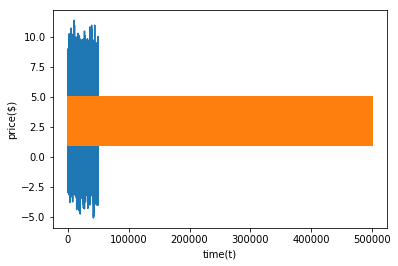

In [60]:
plot_raw_dataset(normal_raw_dataset)
plot_raw_dataset(sine_raw_dataset)

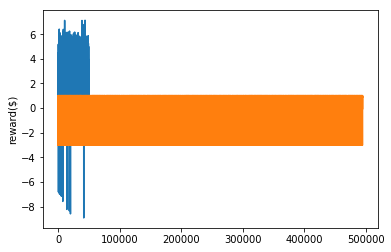

In [61]:
plot_reward_history(normal_mdp_history)
plot_reward_history(sine_mdp_history)

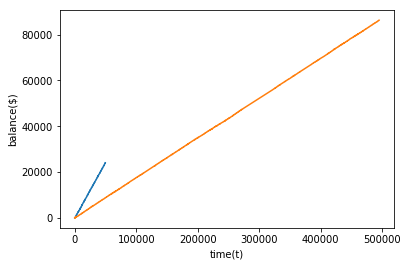

In [62]:
plot_balance_history(normal_mdp_history)
plot_balance_history(sine_mdp_history)

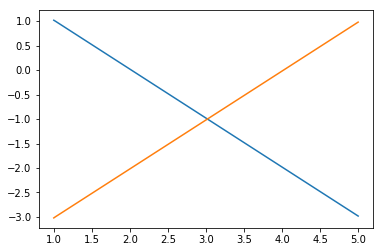

In [63]:
plot_action_utility(sine_accumulate_q_table, sine_distribute_q_table)

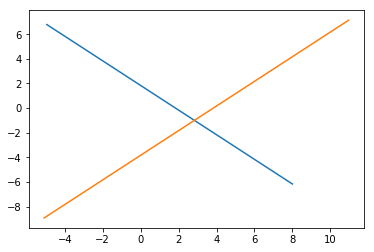

In [64]:
plot_action_utility(normal_accumulate_q_table,  normal_distribute_q_table)

(array([7.55215708e-05, 7.55215708e-05, 3.77607854e-05, 1.51043142e-04,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.15366752e+00, 2.14594544e-01, 1.64448221e-01, 1.24761635e-01,
        8.48484848e-02, 5.75474370e-02, 3.10771264e-02, 1.97866516e-02,
        9.21363164e-03, 4.87114132e-03, 2.03908241e-03, 1.28386670e-03,
        4.90890211e-04, 1.88803927e-04]),
 array([-8.92 , -8.385, -7.85 , -7.315, -6.78 , -6.245, -5.71 , -5.175,
        -4.64 , -4.105, -3.57 , -3.035, -2.5  , -1.965, -1.43 , -0.895,
        -0.36 ,  0.175,  0.71 ,  1.245,  1.78 ,  2.315,  2.85 ,  3.385,
         3.92 ,  4.455,  4.99 ,  5.525,  6.06 ,  6.595,  7.13 ]),
 <a list of 30 Patch objects>)

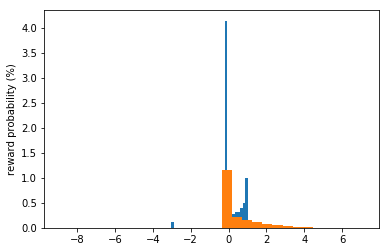

In [65]:
plot_reward_histogram(sine_mdp_history)
plot_reward_histogram(normal_mdp_history)

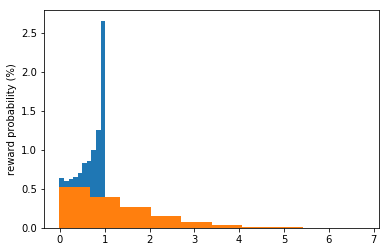

In [66]:
sine_accumulate_rewards = get_reward_histogram(sine_mdp_history, "ACCUMULATE_ACTION")
normal_accumulate_rewards = get_reward_histogram(normal_mdp_history, "ACCUMULATE_ACTION")

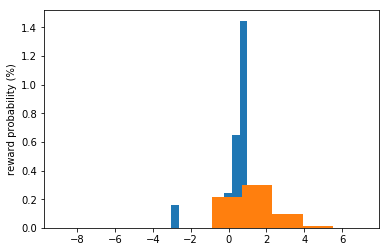

In [67]:
sine_distribute_rewards = get_reward_histogram(sine_mdp_history, "DISTRIBUTE_ACTION")
normal_distribute_rewards = get_reward_histogram(normal_mdp_history, "DISTRIBUTE_ACTION")


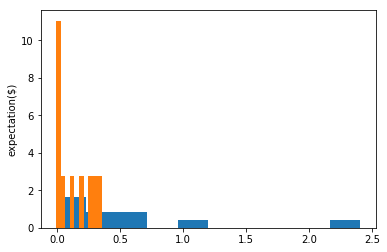

In [68]:
sine_accumulate_expectation = get_expectation_histogram(sine_accumulate_rewards)
normal_accumulate_expectation = get_expectation_histogram(normal_accumulate_rewards)


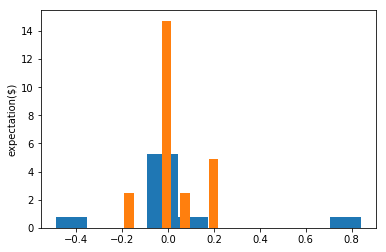

In [69]:
sine_distribute_expectation = get_expectation_histogram(sine_distribute_rewards)
normal_distribute_expectation = get_expectation_histogram(normal_distribute_rewards)

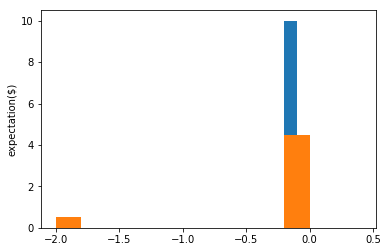

In [70]:
sine_donothing_rewards = get_reward_histogram(sine_mdp_history, "DONOTHING_ACTION")
sine_donothing_expectation = get_expectation_histogram(sine_donothing_rewards)